# Notebook: pyolimp - Примеры симуляции

### 📦 Импорт библиотек

В этом разделе выполняется импорт необходимых модулей:

- `sys` — для добавления пути к корню проекта;
- `torch` — основная библиотека для работы с тензорами;
- `Tensor` — тип из `torch`, используемый для аннотирования аргументов;
- `matplotlib.pylab as plt` — модуль для построения графиков и отображения изображений;
- `pi` из `math` — значение числа π, может использоваться для дальнейших вычислений (хотя в текущей функции не используется).

In [46]:
import sys
sys.path.append("../../../")

In [47]:
import torch
from torch import Tensor
from matplotlib import pylab as plt
from math import pi

### 🖼️ Визуализация изображения

Функция `show_one` используется для отображения одного изображения с заголовком.  
Перед выводом она проверяет наличие `NaN` в тензоре, чтобы избежать ошибок отображения.

In [48]:
def show_one(image: Tensor, title: str) -> None:
    if image.isnan().any():
        raise ValueError("has nan")
    fig, ax1 = plt.subplots(dpi=72, figsize=(6, 4.5), ncols=1, nrows=1)
    plt.title(title)
    ax1.imshow(image)

### 🔍 Метод SCA (Simplified Conic Approximation)

Метод **SCA** — приближённая модель построения **Функции Рассеяния Точки (ФРТ)**  
для моделирования искажений изображения, вызванных аберрациями зрения.  
ФРТ формируется в виде **нормализованного эллипса**, параметры которого  
задаются сферической и цилиндрической составляющими, а также осью астигматизма.

#### 🧾 Вход:
- сферическая аберрация `sphere_dpt` (в диоптриях);
- цилиндрическая аберрация `cylinder_dpt` (в диоптриях);
- угол астигматизма `angle_rad` (в радианах);
- диаметр зрачка `pupil_diameter_mm` (в мм);
- масштаб `am2px` (угловые минуты в пиксели);
- размер ФРТ (ширина и высота, например 64×64 пикселя).

#### 📤 Выход:
- **ФРТ**: 2D тензор `Tensor[H, W]`,  
  значащий нормализованное распределение интенсивности,  
  задающее форму и направление искажений изображения.

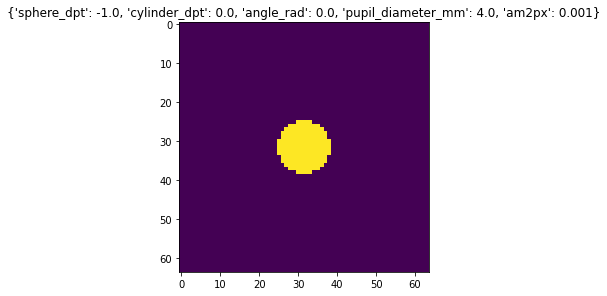

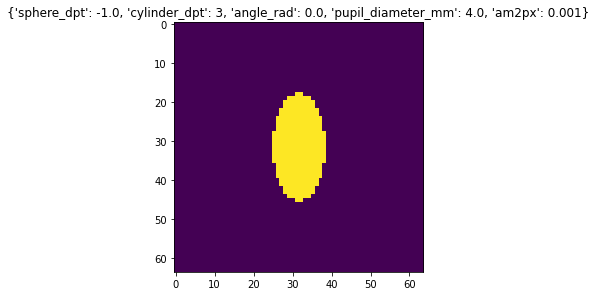

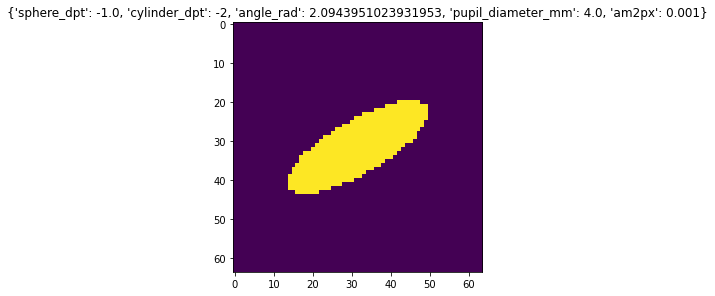

In [49]:
from olimp.simulate.psf_sca import PSFSCA


params = {
    "sphere_dpt": -1.0,
    "cylinder_dpt": 0.0,
    "angle_rad": 0.0,
    "pupil_diameter_mm": 4.0,
    "am2px": 0.001,
}

params1 = {**params}
show_one(PSFSCA(64, 64)(**params1), f"{params1}")
params2 = {**params, "cylinder_dpt": 3}
show_one(PSFSCA(64, 64)(**params2), f"{params2}")
params3 = {**params, "cylinder_dpt": -2, "angle_rad": pi / 1.5}
show_one(PSFSCA(64, 64)(**params3), f"{params3}")

### 🗃️ Класс `PSFSCADataset`

Класс **PSFSCADataset** наследуется от абстрактного класса `DistortionDataset`  
и реализует генератор набора **Функций Рассеяния Точки (ФРТ)**, полученных с помощью физиологической модели зрения **SCA-2023**.  
Модель учитывает сферические и цилиндрические ошибки рефракции, угол астигматизма и диаметр зрачка.

#### 🧾 Параметры конструктора:
- **width**, **height** — размеры выходного ФРТ в пикселях (например, `512×512`).
- **sphere_dpt** — распределение сферической составляющей рефракции (в диоптриях); словарь:
  - `name`: тип распределения, например `"uniform"`
  - `a`, `b`: границы диапазона, например `a = -4.0`, `b = -2.0`
- **cylinder_dpt** — распределение цилиндрической составляющей (в диоптриях); аналогично `sphere_dpt`.
- **angle_deg** — распределение угла астигматизма в градусах; например `a = 0.0`, `b = 180.0`.
- **pupil_diameter_mm** — диаметр зрачка в миллиметрах; например `a = 3.0`, `b = 5.0`.
- **am2px** — коэффициент перевода угловых минут в пиксели (например, `0.001`).
- **seed** — начальное значение генератора случайных чисел для воспроизводимости (например, `42`).
- **size** — количество выборок в датасете (например, `100`).

#### 📥 Как использовать:
1. Создайте экземпляр `PSFSCADataset` с нужными параметрами.
2. Получите элемент через `dataset[idx]`, где `idx` от `0` до `size-1`.
3. Каждый элемент — тензор формы `(1, H, W)` — одномерная ФРТ, сформированная моделью глаза.

#### 📤 Выход каждого элемента:
- **ФРТ**: тензор `Tensor[1, H, W]`, соответствующий смоделированному искажению зрения.
- **Параметры выборки**: `sphere_dpt`, `cylinder_dpt`, `angle_deg`, `pupil_diameter_mm` (можно логгировать отдельно).

### 🔁 Метод `apply()`

Метод `apply()` реализует абстрактный метод из `DistortionDataset`.  
Он возвращает генератор, который применяет к изображению искажения зрения,  
используя соответствующую ФРТ и модель преломления `RefractionDistortion`.

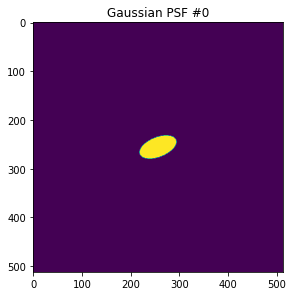

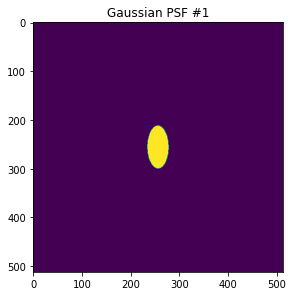

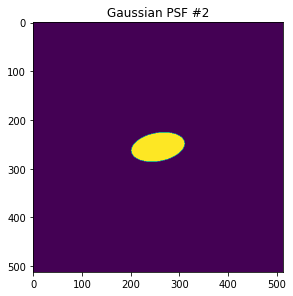

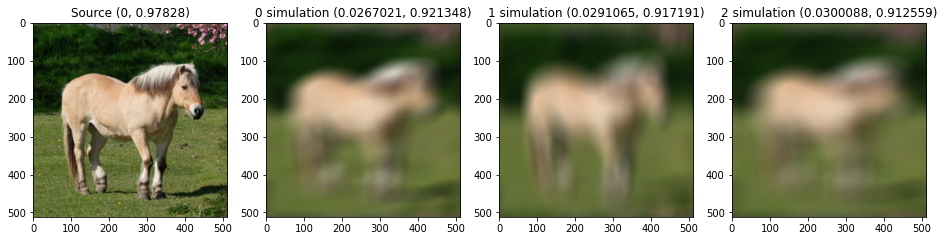

In [50]:
from olimp.precompensation.nn.dataset.psf_sca import PSFSCADataset
from olimp.simulate._demo_distortion import demo

dataset = PSFSCADataset(
    width=512,
    height=512,
    sphere_dpt={"name": "uniform", "a": -4.0, "b": -2.0},       # uniform в диапазоне [-2, 0]
    cylinder_dpt={"name": "uniform", "a": -4.0, "b": -2.0},     # то, что у вас уже было
    angle_deg={"name": "uniform", "a": 0.0,   "b": 180.0},     # то, что у вас уже было
    pupil_diameter_mm={"name": "uniform", "a": 3.0, "b": 5.0}, # uniform, например, от 3 до 5 мм
    am2px=0.001,
    seed=42,
    size=100
)


def demo_simulate():
    apply_fn = dataset.apply()
    funcs = []

    for i in range(3):
        psf = dataset[i]
        show_one(psf[0], title=f"Gaussian PSF #{i}")

        # создаём функцию с захваченным индексом
        funcs.append((
            lambda image, i=i: list(apply_fn(image))[i], f"{i}"
        ))

    return funcs

demo("RefractionDistortion", demo_simulate, on="horse.jpg", size=(512, 512))

### 🔍 Метод PSFGauss (Гауссовская функция рассеяния точки)

Метод **PSFGauss** используется для генерации **функции рассеяния точки (ФРТ)**  
в виде двумерного нормализованного **анизотропного гауссовского распределения**  
с возможностью задания ориентации эллипса и степени размытия по осям.

#### 🧾 Вход:
- `center_x`, `center_y` — координаты центра ФРТ (в пикселях);
- `sigma_x`, `sigma_y` — стандартные отклонения по осям X и Y (характеризуют размытие);
- `theta` — угол поворота эллипса (в радианах);
- размер ФРТ (ширина и высота, например 64×64 пикселя).

#### 📤 Выход:
- **ФРТ**: 2D тензор `Tensor[H, W]`,  
  представляющий собой нормализованную карту интенсивности рассеяния.

> Применяется для имитации искажений, аналогичных оптическому размытию в системах зрения и изображений.


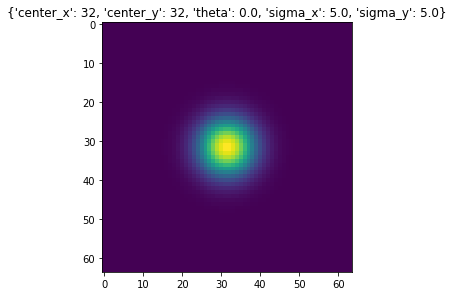

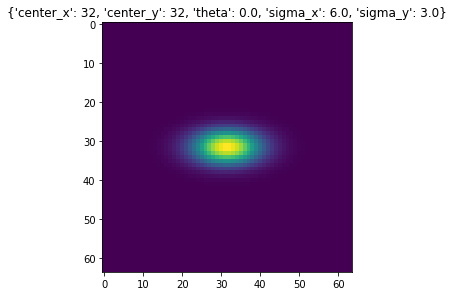

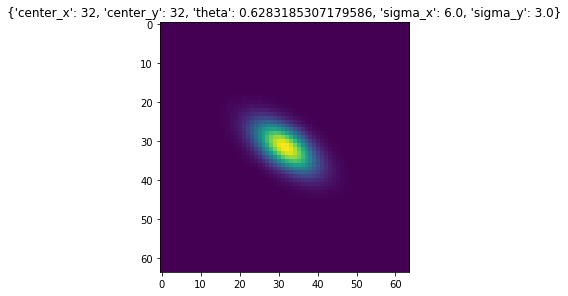

In [51]:
from olimp.simulate.psf_gauss import PSFGauss

params = {
    "center_x": 32,
    "center_y": 32,
    "theta": 0.0,
    "sigma_x": 5.0,
    "sigma_y": 5.0,
}

show_one(PSFGauss(64, 64)(**params), f"{params}")
params2 = {**params, "sigma_x": 6.0, "sigma_y": 3.0}
show_one(PSFGauss(64, 64)(**params2), f"{params2}")
params3 = {**params, "sigma_x": 6.0, "sigma_y": 3.0, "theta": pi / 5}
show_one(PSFGauss(64, 64)(**params3), f"{params3}")

### 🗃️ Класс `PsfGaussDataset`

Класс **PsfGaussDataset** наследуется от абстрактного класса `DistortionDataset`  
и реализует генератор набора **Гауссовских Функций Рассеяния Точки (ФРТ)**  
для синтетической генерации размытий, моделируемых двумерной анизотропной гауссианой,  
а также предоставляет функциональность по применению этих ФРТ к изображениям.

#### 🧾 Параметры конструктора:
- **width**, **height** — размеры выходного ФРТ в пикселях (например, 512×512).
- **center_x** — распределение координаты центра по X; словарь:
  - `name`: тип распределения, например `"uniform"`
  - `a`: нижняя граница диапазона (float), например 255.0
  - `b`: верхняя граница диапазона (float), например 257.0
- **center_y** — распределение координаты центра по Y; аналогично `center_x`.
- **theta** — распределение угла поворота гауссианы в градусах; например `a=0.0`, `b=180.0`.
- **sigma_x** — распределение стандартного отклонения по X (в пикселях); например `a=5.0`, `b=25.0`.
- **sigma_y** — распределение стандартного отклонения по Y (в пикселях); аналогично `sigma_x`.
- **seed** — начальное значение генератора случайных чисел для воспроизводимости (например, 42).
- **size** — общее число выборок в датасете (например, 10000).

#### 📥 Как использовать:
1. Создаёте экземпляр `PsfGaussDataset` с нужными параметрами.
2. Получаете элемент через `dataset[idx]`, где `idx` от 0 до `size-1`.
3. Каждый элемент — тензор формы `(1, H, W)`, содержащий одноканальную гауссовскую ФРТ.

#### 📤 Выход каждого элемента:
- **Гауссовская ФРТ**: 2D тензор `Tensor[1, H, W]` — анизотропная гауссиана с заданными параметрами.
- **Параметры выборки**: `center_x`, `center_y`, `theta`, `sigma_x`, `sigma_y` (можно логгировать вручную).

### 🔁 Метод `apply()`

Метод `apply()` реализует абстрактный метод из базового класса `DistortionDataset`.  
Он возвращает генератор-функцию, которая применяет к изображению искажения,  
имитирующие размытие от различных ФРТ, используя модель преломления `RefractionDistortion`.

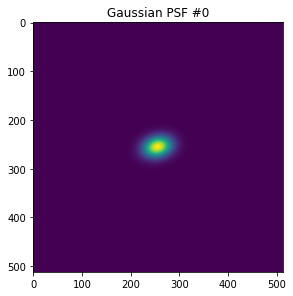

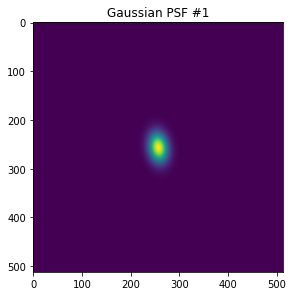

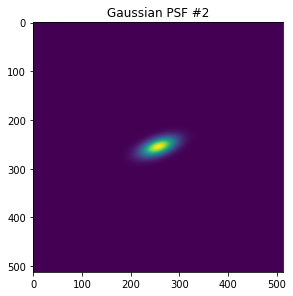

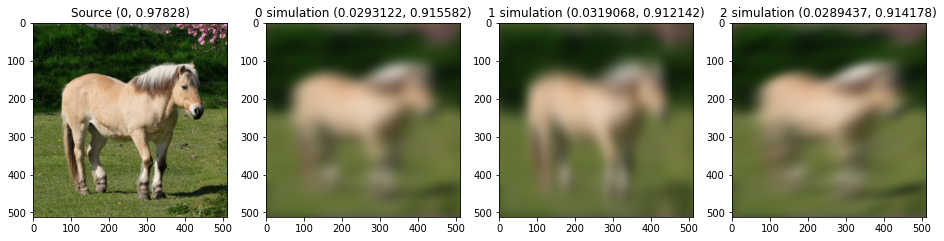

In [52]:
from olimp.precompensation.nn.dataset.psf_gauss import PsfGaussDataset
from olimp.simulate._demo_distortion import demo

dataset = PsfGaussDataset(
    width=512,
    height=512,
    center_x={"name": "uniform", "a": 255.0,  "b": 257.0},   # центр по X в пикселях от 0 до 63
    center_y={"name": "uniform", "a": 255.0,  "b": 257.0},   # центр по Y в пикселях от 0 до 63
    theta={"name": "uniform",   "a": 0.0,  "b": 180.0},   # угол поворота в градусах
    sigma_x={"name": "uniform", "a": 5.0,  "b": 25.0},    # sigma по X в пикселях
    sigma_y={"name": "uniform", "a": 5.0,  "b": 25.0},    # sigma по Y в пикселях
    seed=99,
    size=100
)

def demo_simulate():
    apply_fn = dataset.apply()
    funcs = []

    for i in range(3):
        psf = dataset[i]
        show_one(psf[0], title=f"Gaussian PSF #{i}")

        # создаём функцию с захваченным индексом
        funcs.append((
            lambda image, i=i: list(apply_fn(image))[i], f"{i}"
        ))

    return funcs

demo("RefractionDistortion", demo_simulate, on="horse.jpg", size=(512, 512))


### 👁 Метод RefractionDistortion

Класс **RefractionDistortion** моделирует искажения изображения, вызванные **рефракционными аномалиями** зрения,  
такими как близорукость, дальнозоркость и астигматизм. Метод реализует **свёртку изображения с ФРТ (PSF)**  
в частотной области, что позволяет точно смоделировать эффект, наблюдаемый на сетчатке глаза.

#### 🧾 Вход:
- Функция рассеяния точки `PSF` (тензор `Tensor[H, W]`), сдвинутая с помощью `fftshift`;
- Изображение (при вызове `RefractionDistortion()(image)` внутри пайплайна).

#### 📤 Выход:
- Искажённое изображение, имитирующее восприятие наблюдателем с заданными аберрациями.


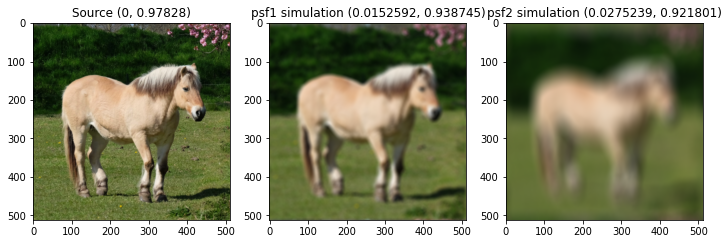

In [53]:
from olimp.simulate.refraction_distortion import RefractionDistortion
from olimp.simulate._demo_distortion import demo


def demo_simulate():
    psf1 = PSFSCA(512, 512)()
    yield RefractionDistortion()(torch.fft.fftshift(psf1)), "psf1"

    psf2 = PSFSCA(512, 512)(sphere_dpt=-3, cylinder_dpt=-2)
    yield RefractionDistortion()(torch.fft.fftshift(psf2)), "psf2"


demo("RefractionDistortion", demo_simulate, on="horse.jpg", size=(512, 512))

### 👁 Метод ColorBlindnessDistortion

Класс **ColorBlindnessDistortion** реализует симуляцию восприятия изображения людьми  
с различными типами **дальтонизма**. Основан на преобразовании изображения в цветовое пространство LMS  
и модификации компонент, имитирующих утрату чувствительности одного из трёх типов колбочек.

#### 🧾 Вход:
- Тип цветовой слепоты:
  - `"protan"` — протанопия (нечувствительность к красному);
  - `"deutan"` — дейтеранопия (нечувствительность к зелёному);
  - `"tritan"` — тританопия (нечувствительность к синему).

#### 📤 Выход:
- Искажённое изображение, соответствующее восприятию человека с указанным типом дальтонизма.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.119602986..1.0000002].


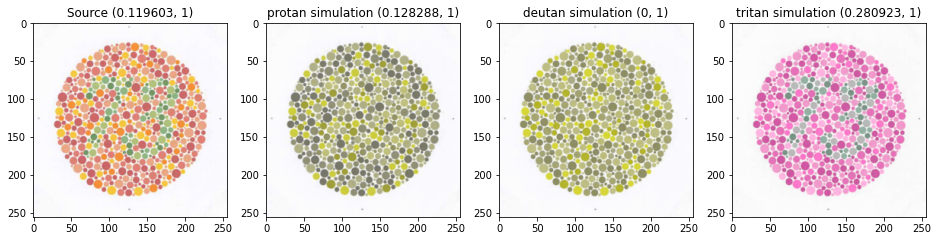

In [54]:
from olimp.simulate.color_blindness_distortion import ColorBlindnessDistortion

def demo_simulate():
    yield ColorBlindnessDistortion.from_type("protan")(), "protan"
    yield ColorBlindnessDistortion.from_type("deutan")(), "deutan"
    yield ColorBlindnessDistortion.from_type("tritan")(), "tritan"


demo("ColorBlindnessDistortion", demo_simulate)

### 🗃️ Класс `ColorBlindnessDataset`

Класс **ColorBlindnessDataset** наследуется от абстрактного класса `DistortionDataset`  
и реализует генератор искажений **цветовой слепоты (дихромазии)**.  
Для каждого индекса создаётся преобразование зрения при определённом угле цветового круга.

#### 🧾 Параметры конструктора:
- **angle_deg** — распределение угла на цветовом круге (в градусах), влияющего на спектр утраты:
  - `name`: тип распределения (например, `"uniform"`)
  - `a`: нижняя граница диапазона (например, `33.0`)
  - `b`: верхняя граница диапазона (например, `360.0`)
- **seed** — значение для инициализации генератора случайных чисел (например, `11`)
- **size** — количество искажений (например, `365`)

#### 📥 Как использовать:
1. Создайте экземпляр `ColorBlindnessDataset` с нужными параметрами.
2. Получите угол через `angle = dataset[idx].item()`, где `idx` от `0` до `size - 1`.
3. Получите функцию искажения через `dataset._distortions[idx]()`.
4. Примените её к изображению: `image_transformed = apply_fn(image)`.

#### 📤 Выход каждого элемента:
- **Угол искажения**: значение типа `float`, в градусах, определяющее ось потери цветов.
- **Функция искажения**: `Callable[[Tensor], Tensor]`, имитирующая дихромазию с заданным углом.

### 🔁 Метод `apply()`

Метод `apply()` реализует абстрактный метод из `DistortionDataset`.  
Он возвращает генератор, который применяет к изображению искажения цветового восприятия,  
используя заранее сгенерированные параметры углов и соответствующие модели `ColorBlindnessDistortion`.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.119602986..1.0000002].


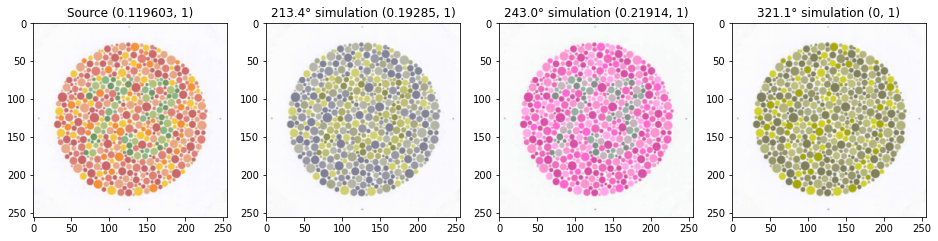

In [55]:
from olimp.precompensation.nn.dataset.cvd_angle import ColorBlindnessDataset

dataset = ColorBlindnessDataset(
    angle_deg={"name": "uniform", "a": 33.0, "b": 360.0},
    seed=11,
    size=365
)

def demo_simulate():
    funcs = []

    for i in range(3):
        angle = dataset[i].item()
        funcs.append((
            lambda image, distortion=dataset._distortions[i]: distortion()(image),
            f"{angle:.1f}°"
        ))

    return funcs

demo("ColorBlindnessDistortion (3 angles)", demo_simulate)
